In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import operator
import sys
import graphviz 
# Non pythonic hack to reuse some utility code
if sys.path[0] != '../py_utils':
    sys.path.insert(0,'../py_utils')

import utils
import sklearn
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics import log_loss
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve
from pathlib import Path
from sklearn.model_selection import GridSearchCV
from time import time
from sklearn import tree
%matplotlib inline
pd.set_option('display.max_columns', 500)
print("Seaborn version: ", sns.__version__)
print("sklearn version: ", sklearn.__version__)

Seaborn version:  0.9.0
sklearn version:  0.20.2


In [3]:
def read_summary_team_data():
    summary_data = pd.read_csv(Path('../data/sr_summaries_kaggle_id_no_opp.csv'))
    # drop opponent stat columns
    summary_data.drop(columns=['allow_fg_pct', 'allow_ft_att_avg', 'allow_off_rebs_avg',
                               'allow_def_rebs_avg'], inplace=True)

    summary_data.dropna(inplace=True)
    summary_data.rename(str.lower, axis='columns', inplace=True)
    return summary_data


In [4]:
def read_team_meta_data():
    teams = pd.read_csv(Path('../data/D1_teams.csv'))
    teams.drop(columns=['code_ncaa', 'school_ncaa', 'turner_name', 'league_name', 'league_alias', 'conf_alias',
                        'conf_id', 'division_name', 'division_alias', 'division_id',
                        'kaggle_team_id', 'venue_id'], inplace=True)

    teams.set_index('id', inplace=True)
    return teams

In [5]:
def read_tournament_results(tournament_season):
    tourney_data = pd.read_csv(Path('../data/tournament_results.csv'))
    tourney_data.drop(
        columns=['days_from_epoch', 'day', 'num_ot', 'academic_year', 'win_region', 'win_alias', 'lose_region',
                 'lose_alias', 'lose_code_ncaa', 'win_school_ncaa', 'win_code_ncaa', 'win_name', 'lose_name',
                 'win_pts', 'win_kaggle_team_id', 'lose_school_ncaa', 'lose_kaggle_team_id', 'lose_pts'], inplace=True)

    tourney_data = tourney_data[tourney_data['season'] >= tournament_season]
    return tourney_data

In [6]:
def recode_tourney_data(tourney_data):
    tourney_data['game_result'] = 1
    tourney_data.game_result = tourney_data.game_result.astype(int)
    tourney_data.rename(columns={"win_seed": "team_seed", "win_market": "team", "win_team_id": "team_id"}, inplace=True)
    tourney_data.rename(columns={"lose_seed": "opp_team_seed", "lose_market": "opp_team",
                                 "lose_team_id": "opp_team_id"}, inplace=True)

    tourney_data['start_season'] = tourney_data['season'] - 1

    # create some temporary buffer columns
    tourney_data['copy_team'] = tourney_data['team']
    tourney_data['copy_team_seed'] = tourney_data['team_seed']
    tourney_data['copy_team_id'] = tourney_data['team_id']

    # swap the team and opp team data
    tourney_data.loc[1::2, 'team'] = tourney_data.loc[1::2, 'opp_team']
    tourney_data.loc[1::2, 'opp_team'] = tourney_data.loc[1::2, 'copy_team']
    tourney_data.loc[1::2, 'team_seed'] = tourney_data.loc[1::2, 'opp_team_seed']
    tourney_data.loc[1::2, 'opp_team_seed'] = tourney_data.loc[1::2, 'copy_team_seed']
    tourney_data.loc[1::2, 'team_id'] = tourney_data.loc[1::2, 'opp_team_id']
    tourney_data.loc[1::2, 'opp_team_id'] = tourney_data.loc[1::2, 'copy_team_id']

    # flip the game result
    tourney_data.loc[1::2, 'game_result'] = 0

    # drop the temporary columns
    tourney_data.drop(columns=['copy_team', 'copy_team_seed', 'copy_team_id'], inplace=True)
    tourney_data.rename(columns={"team_seed": "seed_t", "opp_team_seed": "seed_o"}, inplace=True)

    tourney_data['Game Result'] = tourney_data.game_result.map({1: 'Win', 0: 'Lose'})

    return tourney_data

In [7]:
def merge_tourney_summary_data(tourney_data, summary_data):
    tourney_data = tourney_data.merge(summary_data, left_on=['start_season', 'team_id'],
                                      right_on=['season', 'team_id'], how='left', suffixes=('', '_y'))

    tourney_data.drop(columns=['season_y'], inplace=True)
    tourney_data = tourney_data.merge(summary_data, left_on=['start_season', 'opp_team_id'],
                                      right_on=['season', 'team_id'], how='left', suffixes=('_t', '_o'))

    tourney_data.drop(columns=['school_t', 'school_o', 'games_t', 'games_o', 'team_id_o'], inplace=True)

    return tourney_data

In [8]:
def join_tourney_team_data(tourney_data, teams):
    tourney_data = tourney_data.join(teams, on='team_id_t', how='left')
    tourney_data = tourney_data.join(teams, on='opp_team_id', how='left', lsuffix='_t', rsuffix='_o')
    tourney_data.rename(index=str, columns={'team': 'team_t', 'opp_team': 'team_o', 'opp_team_id': 'team_id_o'},
                        inplace=True)

    tourney_data['game_result'] = tourney_data.game_result.apply(utils.negate_loser)
    return tourney_data

In [9]:
def merge_tourney_ranking_data(tourney_data, computer_rankings):
    temp_merge = tourney_data.merge(computer_rankings, left_on=['season_t', 'team_id_t'],
                                    right_on=['season', 'kaggle_id'], how='left', suffixes=('', '_y'))

    temp_merge.drop(columns=['Team', 'season', 'win_pct', 'kaggle_id'], inplace=True)
    tourney_comp_ratings = temp_merge.merge(computer_rankings, left_on=['season_t', 'team_id_o'],
                                            right_on=['season', 'kaggle_id'], how='left', suffixes=('_t', '_o'))

    tourney_comp_ratings.drop(columns=['Team', 'season', 'win_pct', 'kaggle_id'], inplace=True)

    tourney_comp_ratings.rename(str.lower, axis='columns', inplace=True)
    return tourney_comp_ratings

In [10]:
def compute_delta_features(tourney_comp_ratings):
    tourney_comp_ratings['margin_victory_avg_t'] = tourney_comp_ratings['pts_avg_t'] - tourney_comp_ratings[
        'opp_pts_avg_t']
    tourney_comp_ratings['margin_victory_avg_o'] = tourney_comp_ratings['pts_avg_o'] - tourney_comp_ratings[
        'opp_pts_avg_o']

    tourney_comp_ratings['delta_margin_victory_avg'] = \
        tourney_comp_ratings['margin_victory_avg_t'] - tourney_comp_ratings['margin_victory_avg_o']

    tourney_comp_ratings['delta_fg_pct'] = tourney_comp_ratings['fg_pct_t'] - tourney_comp_ratings['fg_pct_o']

    tourney_comp_ratings['delta_off_rebs_avg'] = tourney_comp_ratings['off_rebs_avg_t'] - tourney_comp_ratings[
        'off_rebs_avg_o']

    tourney_comp_ratings['delta_def_rebs_avg'] = tourney_comp_ratings['def_rebs_avg_t'] - tourney_comp_ratings[
        'def_rebs_avg_o']

    tourney_comp_ratings['delta_ft_pct'] = tourney_comp_ratings['ft_pct_t'] - tourney_comp_ratings['ft_pct_o']

    tourney_comp_ratings['to_net_avg_t'] = tourney_comp_ratings['to_avg_t'] - tourney_comp_ratings['steal_avg_t']

    tourney_comp_ratings['to_net_avg_o'] = tourney_comp_ratings['to_avg_o'] - tourney_comp_ratings['steal_avg_o']

    tourney_comp_ratings['delta_to_net_avg'] = tourney_comp_ratings['to_net_avg_t'] - tourney_comp_ratings[
        'to_net_avg_o']

    tourney_comp_ratings['delta_win_pct'] = tourney_comp_ratings['win_pct_t'] - tourney_comp_ratings['win_pct_o']

    tourney_comp_ratings['delta_off_rating'] = tourney_comp_ratings['off_rating_t'] - tourney_comp_ratings[
        'off_rating_o']

    tourney_comp_ratings['delta_ft_att_avg'] = tourney_comp_ratings['ft_att_avg_t'] - tourney_comp_ratings[
        'ft_att_avg_o']

    tourney_comp_ratings['delta_seed'] = tourney_comp_ratings['seed_t'] - tourney_comp_ratings['seed_o']

    tourney_comp_ratings['delta_srs'] = tourney_comp_ratings['srs_t'] - tourney_comp_ratings['srs_o']
    tourney_comp_ratings['delta_sos'] = tourney_comp_ratings['sos_t'] - tourney_comp_ratings['sos_o']

    tourney_comp_ratings['delta_sag'] = tourney_comp_ratings['sag_t'] - tourney_comp_ratings['sag_o']
    tourney_comp_ratings['delta_wlk'] = tourney_comp_ratings['wlk_t'] - tourney_comp_ratings['wlk_o']
    tourney_comp_ratings['delta_wol'] = tourney_comp_ratings['wol_t'] - tourney_comp_ratings['wol_o']
    tourney_comp_ratings['delta_rth'] = tourney_comp_ratings['rth_t'] - tourney_comp_ratings['rth_o']
    tourney_comp_ratings['delta_col'] = tourney_comp_ratings['col_t'] - tourney_comp_ratings['col_o']
    tourney_comp_ratings['delta_pom'] = tourney_comp_ratings['pom_t'] - tourney_comp_ratings['pom_o']
    tourney_comp_ratings['delta_dol'] = tourney_comp_ratings['dol_t'] - tourney_comp_ratings['dol_o']
    tourney_comp_ratings['delta_rpi'] = tourney_comp_ratings['rpi_t'] - tourney_comp_ratings['rpi_o']
    tourney_comp_ratings['delta_mor'] = tourney_comp_ratings['mor_t'] - tourney_comp_ratings['mor_o']

    tourney_comp_ratings.drop(columns=['season_o'], inplace=True)
    tourney_comp_ratings.dropna(inplace=True)
    return tourney_comp_ratings

In [11]:
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

#### Read in regular season team statistics from SRCBB https://www.sports-reference.com/cbb/

#### Read table of team names and associated team meta data from the Kaggle data set.

https://console.cloud.google.com/bigquery?project=bigqueryncaa&p=bigquery-public-data&d=ncaa_basketball&page=dataset

#### Read in the NCAA Men's Tournament results from the the Kaggle data set.

In [12]:
# earliest season data starts in 2002 corresponding to tournament season date of 2003
tournament_season = 2003
summary_data = read_summary_team_data()
teams = read_team_meta_data()
tourney_data = read_tournament_results(tournament_season)
game_data = utils.compute_game_data(tourney_data, teams)
computer_rankings = pd.read_csv(Path('../data/massey_seasons_with_id.csv'))
computer_rankings = computer_rankings[computer_rankings['season'] >= tournament_season]

In [13]:
tourney_data = recode_tourney_data(tourney_data)
tourney_data = merge_tourney_summary_data(tourney_data, summary_data)
tourney_data = join_tourney_team_data(tourney_data, teams)

In [14]:
tourney_comp_ratings = merge_tourney_ranking_data(tourney_data, computer_rankings)
tourney_comp_ratings = utils.implement_top_conference_feature(tourney_data, teams, game_data, tourney_comp_ratings)
tourney_comp_ratings = utils.implement_seed_threshold_feature(tourney_comp_ratings)
tourney_comp_ratings = compute_delta_features(tourney_comp_ratings)

In [15]:
tourney_comp_ratings[tourney_comp_ratings.isnull().any(axis=1)]
tourney_comp_ratings.dropna(inplace=True)


In [16]:
tourney_comp_ratings[tourney_comp_ratings.isnull().any(axis=1)]

,season_t,round,game_date,seed_t,team_t,team_id_t,seed_o,team_o,team_id_o,game_result,start_season,game result,srs_t,sos_t,win_pct_t,pts_avg_t,opp_pts_avg_t,fg_pct_t,ft_pct_t,poss_avg_t,off_rebs_avg_t,def_rebs_avg_t,to_avg_t,steal_avg_t,off_rating_t,ft_att_avg_t,srs_o,sos_o,win_pct_o,pts_avg_o,opp_pts_avg_o,fg_pct_o,ft_pct_o,poss_avg_o,off_rebs_avg_o,def_rebs_avg_o,to_avg_o,steal_avg_o,off_rating_o,ft_att_avg_o,conf_name_t,conf_name_o,sag_t,wlk_t,wol_t,rth_t,col_t,pom_t,dol_t,rpi_t,mor_t,sag_o,wlk_o,wol_o,rth_o,col_o,pom_o,dol_o,rpi_o,mor_o,top_conf_t,top_conf_o,upset_seed_threshold,margin_victory_avg_t,margin_victory_avg_o,delta_margin_victory_avg,delta_fg_pct,delta_off_rebs_avg,delta_def_rebs_avg,delta_ft_pct,to_net_avg_t,to_net_avg_o,delta_to_net_avg,delta_win_pct,delta_off_rating,delta_ft_att_avg,delta_seed,delta_srs,delta_sos,delta_sag,delta_wlk,delta_wol,delta_rth,delta_col,delta_pom,delta_dol,delta_rpi,delta_mor


In [17]:
feature_data = tourney_comp_ratings.drop(columns=['round','game_date','seed_t','team_t','team_id_t','team_id_o',
                                         'team_o','seed_o','team_id_o','game_result','start_season','game result',
                                         'conf_name_t','conf_name_o']).copy()


feature_data.head()

,season_t,srs_t,sos_t,win_pct_t,pts_avg_t,opp_pts_avg_t,fg_pct_t,ft_pct_t,poss_avg_t,off_rebs_avg_t,def_rebs_avg_t,to_avg_t,steal_avg_t,off_rating_t,ft_att_avg_t,srs_o,sos_o,win_pct_o,pts_avg_o,opp_pts_avg_o,fg_pct_o,ft_pct_o,poss_avg_o,off_rebs_avg_o,def_rebs_avg_o,to_avg_o,steal_avg_o,off_rating_o,ft_att_avg_o,sag_t,wlk_t,wol_t,rth_t,col_t,pom_t,dol_t,rpi_t,mor_t,sag_o,wlk_o,wol_o,rth_o,col_o,pom_o,dol_o,rpi_o,mor_o,top_conf_t,top_conf_o,upset_seed_threshold,margin_victory_avg_t,margin_victory_avg_o,delta_margin_victory_avg,delta_fg_pct,delta_off_rebs_avg,delta_def_rebs_avg,delta_ft_pct,to_net_avg_t,to_net_avg_o,delta_to_net_avg,delta_win_pct,delta_off_rating,delta_ft_att_avg,delta_seed,delta_srs,delta_sos,delta_sag,delta_wlk,delta_wol,delta_rth,delta_col,delta_pom,delta_dol,delta_rpi,delta_mor
0,2013,14.32,7.17,0.686,77.0,70.0,0.496,0.681,78.434286,11.0,22.0,12.0,6.0,98.171354,23.0,9.52,5.20,0.706,72.0,67.0,0.428,0.723,77.494118,11.0,19.0,10.0,7.0,92.910278,20.0,25,27.0,36,28,32.0,35.0,32.0,33.0,24,55,58.0,35,47,40.0,68.0,45.0,41.0,52,0,0,0,7.0,5.0,2.0,0.068,0.0,3.0,-0.042,6.0,3.0,3.0,-0.020,5.261076,3.0,-1,4.80,1.97,-30,-31.0,1,-19,-8.0,-33.0,-13.0,-8.0,-28
1,2011,12.35,4.23,0.765,70.0,62.0,0.447,0.698,75.688235,11.0,24.0,10.0,6.0,92.484651,19.0,11.98,11.45,0.559,63.0,62.0,0.439,0.724,68.341176,9.0,21.0,10.0,4.0,92.184541,16.0,32,30.0,25,32,27.0,38.0,25.0,30.0,45,45,42.0,43,37,39.0,39.0,39.0,39.0,27,0,0,0,8.0,1.0,7.0,0.008,2.0,3.0,-0.026,4.0,6.0,-2.0,0.206,0.300109,3.0,-3,0.37,-7.22,-13,-12.0,-18,-5,-12.0,-1.0,-14.0,-9.0,18
2,2013,8.11,0.18,0.788,71.0,62.0,0.455,0.643,78.884848,12.0,21.0,13.0,7.0,90.004610,20.0,16.89,4.47,0.750,76.0,64.0,0.450,0.701,81.044444,13.0,18.0,11.0,11.0,93.775706,18.0,62,55.0,52,59,50.0,54.0,46.0,42.0,60,26,19.0,27,27,27.0,21.0,31.0,24.0,16,0,0,1,9.0,12.0,-3.0,0.005,-1.0,3.0,-0.058,6.0,0.0,6.0,0.038,-3.771096,2.0,7,-8.78,-4.29,36,36.0,25,32,23.0,33.0,15.0,18.0,44
3,2012,8.79,0.63,0.806,68.0,59.0,0.410,0.685,76.305556,12.0,18.0,11.0,10.0,89.115399,20.0,17.42,3.80,0.818,77.0,62.0,0.482,0.748,77.496970,10.0,24.0,12.0,6.0,99.358724,19.0,50,43.0,32,54,35.0,47.0,33.0,38.0,55,10,10.0,16,16,11.0,10.0,15.0,12.0,10,0,1,1,9.0,15.0,-6.0,-0.072,2.0,-6.0,-0.063,1.0,6.0,-5.0,-0.012,-10.243325,1.0,7,-8.63,-3.17,40,33.0,16,38,24.0,37.0,18.0,26.0,45
4,2011,24.10,7.62,0.921,81.0,64.0,0.508,0.679,80.126316,11.0,27.0,13.0,7.0,101.090384,22.0,8.56,3.78,0.700,71.0,66.0,0.434,0.715,75.240000,10.0,21.0,11.0,8.0,94.364700,20.0,2,2.0,3,2,1.0,3.0,2.0,1.0,3,77,55.0,54,74,59.0,84.0,72.0,49.0,80,1,0,1,17.0,5.0,12.0,0.074,1.0,6.0,-0.036,6.0,3.0,3.0,0.221,6.725684,2.0,-10,15.54,3.84,-75,-53.0,-51,-72,-58.0,-81.0,-70.0,-48.0,-77


In [18]:
feature_data.drop(columns=['pts_avg_t','pts_avg_o', 'opp_pts_avg_t','opp_pts_avg_o',
                                'margin_victory_avg_t', 'margin_victory_avg_o',
                                'poss_avg_t','poss_avg_o',
                                'fg_pct_t','fg_pct_o',
                                'off_rebs_avg_t','off_rebs_avg_o','def_rebs_avg_t','def_rebs_avg_o',
                                'ft_pct_t','ft_pct_o',
                                'to_avg_t','to_avg_o','steal_avg_t','steal_avg_o',
                                'to_net_avg_t','to_net_avg_o',
                                'win_pct_t','win_pct_o','off_rating_t','off_rating_o',
                                'ft_att_avg_t','ft_att_avg_o','opp_pts_avg_t','opp_pts_avg_o',
                                'srs_t','srs_o','sos_t','sos_o',
                                'sag_t','sag_o','wlk_t','wlk_o','wol_t','wol_o',
                                'rth_t','rth_o','col_t','col_o','pom_t','pom_o',
                                'dol_t','dol_o','rpi_t','rpi_o','mor_t','mor_o'], inplace=True)



# for now drop the delta seed features
feature_data.drop(columns=['upset_seed_threshold'], inplace=True)
feature_data.head()

,season_t,top_conf_t,top_conf_o,delta_margin_victory_avg,delta_fg_pct,delta_off_rebs_avg,delta_def_rebs_avg,delta_ft_pct,delta_to_net_avg,delta_win_pct,delta_off_rating,delta_ft_att_avg,delta_seed,delta_srs,delta_sos,delta_sag,delta_wlk,delta_wol,delta_rth,delta_col,delta_pom,delta_dol,delta_rpi,delta_mor
0,2013,0,0,2.0,0.068,0.0,3.0,-0.042,3.0,-0.020,5.261076,3.0,-1,4.80,1.97,-30,-31.0,1,-19,-8.0,-33.0,-13.0,-8.0,-28
1,2011,0,0,7.0,0.008,2.0,3.0,-0.026,-2.0,0.206,0.300109,3.0,-3,0.37,-7.22,-13,-12.0,-18,-5,-12.0,-1.0,-14.0,-9.0,18
2,2013,0,0,-3.0,0.005,-1.0,3.0,-0.058,6.0,0.038,-3.771096,2.0,7,-8.78,-4.29,36,36.0,25,32,23.0,33.0,15.0,18.0,44
3,2012,0,1,-6.0,-0.072,2.0,-6.0,-0.063,-5.0,-0.012,-10.243325,1.0,7,-8.63,-3.17,40,33.0,16,38,24.0,37.0,18.0,26.0,45
4,2011,1,0,12.0,0.074,1.0,6.0,-0.036,3.0,0.221,6.725684,2.0,-10,15.54,3.84,-75,-53.0,-51,-72,-58.0,-81.0,-70.0,-48.0,-77


In [19]:
X= feature_data[feature_data['season_t']>= tournament_season]
y=tourney_comp_ratings[tourney_comp_ratings['season_t']>= tournament_season]['game_result']
X= X.drop(columns=['season_t'])

feature_list = list(X)
feature_list

['top_conf_t',
 'top_conf_o',
 'delta_margin_victory_avg',
 'delta_fg_pct',
 'delta_off_rebs_avg',
 'delta_def_rebs_avg',
 'delta_ft_pct',
 'delta_to_net_avg',
 'delta_win_pct',
 'delta_off_rating',
 'delta_ft_att_avg',
 'delta_seed',
 'delta_srs',
 'delta_sos',
 'delta_sag',
 'delta_wlk',
 'delta_wol',
 'delta_rth',
 'delta_col',
 'delta_pom',
 'delta_dol',
 'delta_rpi',
 'delta_mor']

####  Train Validate Test

In [36]:
X_train_validate, X_test, y_train_validate, y_test = train_test_split(X, y, test_size=0.2, random_state= 5)
X_train_1, X_validate, y_train_1, y_validate = train_test_split(X_train_validate, y_train_validate, test_size=0.25, random_state = 5)
print("Total games= ", X.shape[0])
print("X Train_1: ",X_train_1.shape)
print("y_train_1", y_train_1.shape)
print("X Validate: ",X_validate.shape)
print("y_validate", y_validate.shape)
print("X Test: ",X_test.shape)
print(y_test.shape)

Total games=  978
X Train_1:  (586, 23)
y_train_1 (586,)
X Validate:  (196, 23)
y_validate (196,)
X Test:  (196, 23)
(196,)


In [37]:
number_estimators = 201
algorithm_choice = "SAMME.R"
bdt= AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), algorithm=algorithm_choice, n_estimators=number_estimators)
    
bdt.fit(X_train_1, y_train_1)
score = bdt.score(X_train_1, y_train_1)
print("Training Model Score= ", score)


Training Model Score=  0.9778156996587031


In [38]:
param_grid ={
    "n_estimators": [51,101,201,301,401,501,601],
    "learning_rate": [0.01, .05, .1, .5, 1,5]
}

grid_search = GridSearchCV( AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),algorithm=algorithm_choice), 
                           param_grid=param_grid, cv=5)

start = time()
grid_search.fit(X_validate, y_validate)

print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(grid_search.cv_results_['params'])))
report(grid_search.cv_results_)


C:\Users\CHIPK\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV took 57.50 seconds for 42 candidate parameter settings.
Model with rank: 1
Mean validation score: 0.719 (std: 0.060)
Parameters: {'learning_rate': 1, 'n_estimators': 501}

Model with rank: 2
Mean validation score: 0.714 (std: 0.067)
Parameters: {'learning_rate': 1, 'n_estimators': 301}

Model with rank: 2
Mean validation score: 0.714 (std: 0.055)
Parameters: {'learning_rate': 1, 'n_estimators': 601}



In [39]:
number_estimators = 501

bdt= AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), algorithm=algorithm_choice, n_estimators=number_estimators,
                       learning_rate = 1)

X_train = pd.concat([X_train_1, X_validate])
y_train = pd.concat([y_train_1, y_validate])
print("X Train: ",X_train.shape)
print(y_train.shape)

bdt.fit(X_train, y_train)
score = bdt.score(X_train, y_train)
print("Training Model Score= ", score)

X Train:  (782, 23)
(782,)
Training Model Score=  0.9910485933503836


In [40]:
important_features = utils.display_important_features( bdt.feature_importances_, X_train)

Coefficient Values
delta_sos   0.14770459081836326
delta_win_pct   0.14171656686626746
delta_dol   0.06786427145708583
delta_fg_pct   0.0658682634730539
delta_col   0.06387225548902195
delta_srs   0.06187624750499002
delta_off_rating   0.05189620758483034
delta_rpi   0.0499001996007984
delta_mor   0.0499001996007984
delta_ft_pct   0.03792415169660679
delta_rth   0.03592814371257485
delta_margin_victory_avg   0.031936127744510975
delta_wlk   0.031936127744510975
delta_wol   0.031936127744510975
delta_sag   0.02594810379241517
delta_ft_att_avg   0.023952095808383235
delta_pom   0.023952095808383235
delta_off_rebs_avg   0.015968063872255488
delta_to_net_avg   0.015968063872255488
delta_seed   0.015968063872255488
delta_def_rebs_avg   0.005988023952095809
top_conf_t   0.001996007984031936
top_conf_o   0.0


In [42]:
feature_dict={}
threshold_dict = {}
for stub_estimator in bdt.estimators_:
    stub_tree = stub_estimator.tree_
    stub_feature_index = stub_tree.feature[0]
    stub_feature = X_train.columns[stub_feature_index]
    if stub_feature in feature_dict:
        feature_dict[stub_feature] +=1
        threshold_dict[stub_feature].append(stub_tree.threshold[0])
    else:
        feature_dict[stub_feature] = 1
        threshold_dict[stub_feature] = []
        threshold_dict[stub_feature].append(stub_tree.threshold[0])
        

feature_dict


{'delta_srs': 31,
 'delta_win_pct': 71,
 'delta_sos': 74,
 'delta_sag': 13,
 'delta_dol': 34,
 'delta_ft_att_avg': 12,
 'delta_seed': 8,
 'delta_rth': 18,
 'delta_ft_pct': 19,
 'delta_fg_pct': 33,
 'delta_rpi': 25,
 'delta_margin_victory_avg': 16,
 'delta_off_rebs_avg': 8,
 'delta_to_net_avg': 8,
 'delta_wol': 16,
 'delta_wlk': 16,
 'delta_mor': 25,
 'delta_col': 32,
 'delta_off_rating': 26,
 'delta_pom': 12,
 'delta_def_rebs_avg': 3,
 'top_conf_t': 1}

In [43]:
labels = list(feature_dict.keys())
labels


['delta_srs',
 'delta_win_pct',
 'delta_sos',
 'delta_sag',
 'delta_dol',
 'delta_ft_att_avg',
 'delta_seed',
 'delta_rth',
 'delta_ft_pct',
 'delta_fg_pct',
 'delta_rpi',
 'delta_margin_victory_avg',
 'delta_off_rebs_avg',
 'delta_to_net_avg',
 'delta_wol',
 'delta_wlk',
 'delta_mor',
 'delta_col',
 'delta_off_rating',
 'delta_pom',
 'delta_def_rebs_avg',
 'top_conf_t']

Delta Win Count=  1    71
Name: count, dtype: int64


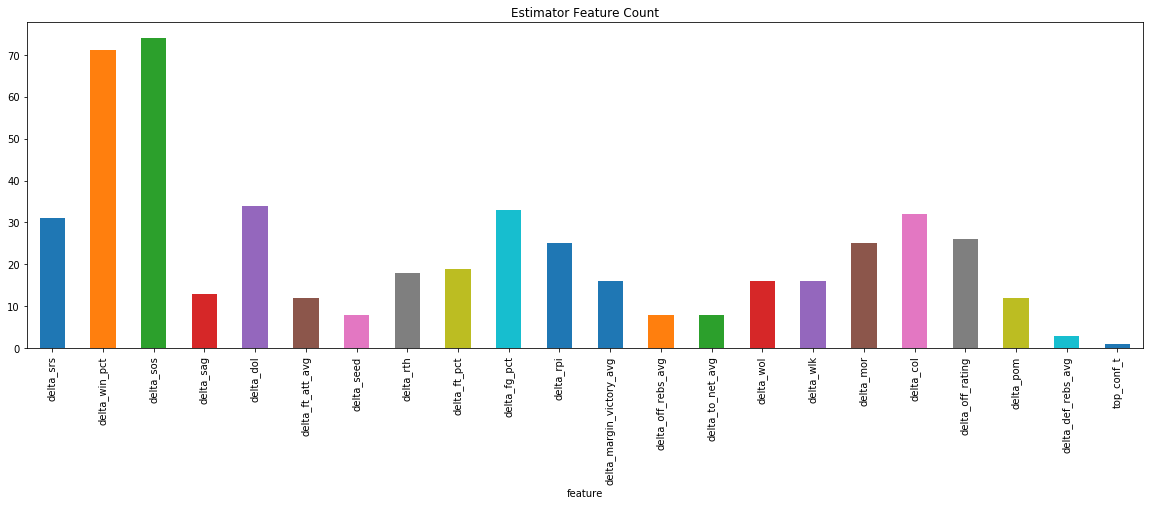

In [44]:
values = list(feature_dict.values())
values

df = pd.DataFrame({'feature':labels, 'count':values})
ax = df.plot.bar(x='feature', y='count', legend=None)
ax.set_title('Estimator Feature Count')
ax.figure.set_size_inches(20,6)
print("Delta Win Count= ",df[df['feature']=='delta_win_pct']['count'])


Number of unique partitions=  27  out of  71  estimators


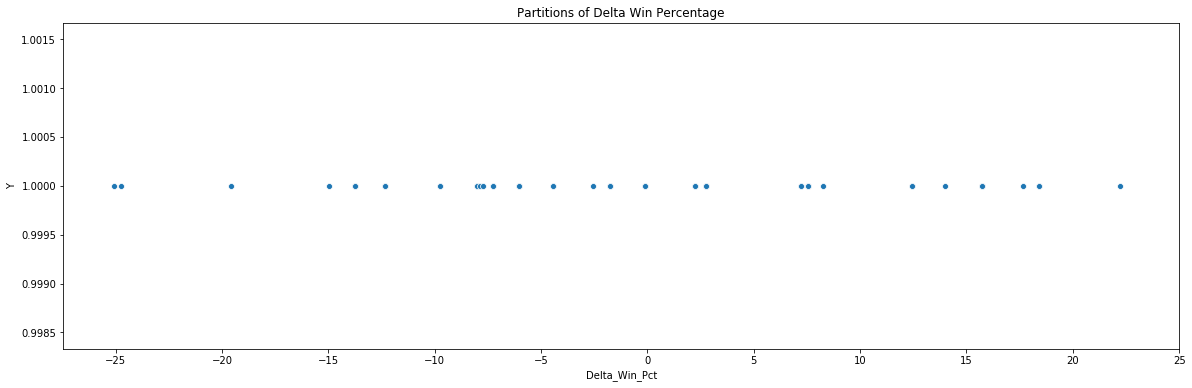

In [76]:
delta_win_partitions = threshold_dict['delta_win_pct']
delta_win_partitions = [i*100 for i in delta_win_partitions]

df_win = pd.DataFrame(columns=['Delta_Win_Pct','Y'])
df_win['Delta_Win_Pct'] = delta_win_partitions
df_win['Y'] = 1
df_win.sort_values(by='Delta_Win_Pct', inplace=True)
print("Number of unique partitions= ",df_win['Delta_Win_Pct'].unique().shape[0], " out of ", df_win.shape[0], ' estimators')

splot = sns.scatterplot(x='Delta_Win_Pct', y='Y', data=df_win)
splot.figure.set_size_inches(20,6)
splot.set_title('Partitions of Delta Win Percentage')
splot.set_xticks(np.arange(-25,30,5))
plt.show()

#### Why are there so many duplicate estimators (62%) for delta_win_pct estimators?

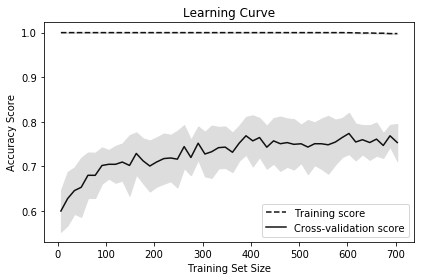

In [46]:
train_sizes, train_scores, test_scores = learning_curve(bdt, X_train, y_train, cv=10, scoring='accuracy',
                                                        n_jobs=-1, 
                                                        train_sizes=np.linspace(0.01, 1.0, 50))

# Create means and standard deviations of training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Create means and standard deviations of test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Draw lines
plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
plt.plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")

# Draw bands
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

# Create plot
plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

#### Test

In [47]:
y_pred = bdt.predict(X_test)
print("AdaBoost model accuracy is %2.2f" % metrics.accuracy_score(y_test, y_pred))

AdaBoost model accuracy is 0.79


array([[71, 24],
       [17, 84]], dtype=int64)

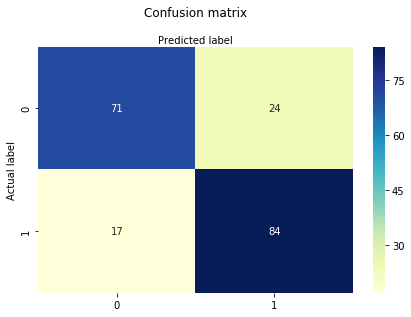

In [48]:
utils.display_confusion_matrix(y_test, y_pred)

In [49]:
prediction_probabilities = bdt.predict_proba(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
print("Log loss= ",log_loss(y_test, prediction_probabilities))

Accuracy: 0.7908163265306123
Precision: 0.7777777777777778
Recall: 0.8316831683168316
Log loss=  0.6813561299301819


In [50]:
cross_val_scores = cross_val_score(bdt, X,y, cv=10, scoring='accuracy')
print("Cross Validation average= ",cross_val_scores.mean())

Cross Validation average=  0.7770776351777824


In [51]:
# Retrieve the non-normalized game stats
prediction_probabilities[:,1]
pred_probs = pd.Series(prediction_probabilities[:,1], index=X_test.index)
predictions = pd.Series(y_pred, index=y_test.index)
test_games = tourney_comp_ratings[tourney_comp_ratings.index.isin(X_test.index)].copy()

test_games['predicted_result'] = predictions
test_games['pred_win_prob'] = pred_probs
#test_games.head()

missed_predictions = test_games[test_games['game_result'] != 
                                test_games['predicted_result']].sort_values(by='pred_win_prob', ascending=False)

print("Missed predictions= ", missed_predictions.shape[0])
missed_predictions

Missed predictions=  41


,season_t,round,game_date,seed_t,team_t,team_id_t,seed_o,team_o,team_id_o,game_result,start_season,game result,srs_t,sos_t,win_pct_t,pts_avg_t,opp_pts_avg_t,fg_pct_t,ft_pct_t,poss_avg_t,off_rebs_avg_t,def_rebs_avg_t,to_avg_t,steal_avg_t,off_rating_t,ft_att_avg_t,srs_o,sos_o,win_pct_o,pts_avg_o,opp_pts_avg_o,fg_pct_o,ft_pct_o,poss_avg_o,off_rebs_avg_o,def_rebs_avg_o,to_avg_o,steal_avg_o,off_rating_o,ft_att_avg_o,conf_name_t,conf_name_o,sag_t,wlk_t,wol_t,rth_t,col_t,pom_t,dol_t,rpi_t,mor_t,sag_o,wlk_o,wol_o,rth_o,col_o,pom_o,dol_o,rpi_o,mor_o,top_conf_t,top_conf_o,upset_seed_threshold,margin_victory_avg_t,margin_victory_avg_o,delta_margin_victory_avg,delta_fg_pct,delta_off_rebs_avg,delta_def_rebs_avg,delta_ft_pct,to_net_avg_t,to_net_avg_o,delta_to_net_avg,delta_win_pct,delta_off_rating,delta_ft_att_avg,delta_seed,delta_srs,delta_sos,delta_sag,delta_wlk,delta_wol,delta_rth,delta_col,delta_pom,delta_dol,delta_rpi,delta_mor,predicted_result,pred_win_prob
904,2004,64,2004-03-18,9,Southern Illinois,7cdfcf92-7fe7-46f1-9b66-6912114182e6,8,Alabama,c2104cdc-c83d-40d2-a3cd-df986e29f5d3,-1,2003,Lose,10.70,2.64,0.833,71.0,62.0,0.443,0.689,78.366667,13.0,22.0,12.0,10.0,90.599745,18.0,14.29,10.20,0.606,72.0,68.0,0.451,0.709,76.333333,11.0,23.0,12.0,6.0,94.323144,22.0,Missouri Valley,Southeastern,36,31.0,27,39,22.0,45.0,19.0,25.0,58,33,36.0,31,28,39.0,34.0,45.0,26.0,27,0,1,0,9.0,4.0,5.0,-0.008,2.0,-1.0,-0.020,2.0,6.0,-4.0,0.227,-3.723399,-4.0,1,-3.59,-7.56,3,-5.0,-4,11,-17.0,11.0,-26.0,-1.0,31,1,0.518690
648,2015,32,2015-03-21,1,Villanova,4383eb6a-7fd8-4ff2-94c5-43c933121e88,8,North Carolina State,52df1e19-b142-4a76-a439-ad68455d0581,-1,2014,Lose,23.13,7.55,0.917,76.0,60.0,0.470,0.731,73.861111,10.0,24.0,10.0,7.0,102.895825,22.0,14.11,9.72,0.611,70.0,65.0,0.436,0.686,75.550000,12.0,25.0,10.0,3.0,92.653872,20.0,Big East,Atlantic Coast,6,4.0,2,2,2.0,5.0,2.0,2.0,4,32,33.0,40,32,40.0,38.0,40.0,39.0,22,0,0,1,16.0,5.0,11.0,0.034,-2.0,-1.0,0.045,3.0,7.0,-4.0,0.306,10.241954,2.0,-7,9.02,-2.17,-26,-29.0,-38,-30,-38.0,-33.0,-38.0,-37.0,-18,1,0.518075
416,2003,68,2003-03-18,16,Texas Southern,eb157f98-0697-459c-9293-ddb162ceb28b,16,UNC Asheville,ad9fce12-6b1a-400c-bcbe-29d84d065fc0,-1,2002,Lose,-9.57,-11.21,0.581,73.0,71.0,0.448,0.612,82.045161,13.0,24.0,15.0,6.0,88.975387,28.0,-13.19,-5.61,0.469,72.0,78.0,0.433,0.761,82.125000,12.0,23.0,16.0,7.0,87.671233,20.0,Southwestern Athletic,Big South,257,240.0,246,256,212.0,268.0,239.0,217.0,293,251,237.0,220,250,213.0,273.0,258.0,186.0,277,0,0,0,2.0,-6.0,8.0,0.015,1.0,1.0,-0.149,9.0,9.0,0.0,0.112,1.304154,8.0,0,3.62,-5.60,6,3.0,26,6,-1.0,-5.0,-19.0,31.0,16,1,0.506326
814,2008,64,2008-03-20,14,Georgia,4f4b0771-994c-4126-822d-7525aaa00f65,3,Xavier,0d8a328f-20ce-410b-bed1-15fc01308aaf,-1,2007,Lose,7.24,7.03,0.500,68.0,67.0,0.429,0.679,79.829412,13.0,24.0,14.0,6.0,85.181637,18.0,17.17,5.47,0.811,75.0,63.0,0.474,0.749,75.335135,11.0,24.0,12.0,5.0,99.555141,22.0,Southeastern,Big East,117,148.0,142,104,143.0,101.0,137.0,152.0,79,10,10.0,12,13,11.0,15.0,12.0,9.0,18,0,0,1,1.0,12.0,-11.0,-0.045,2.0,0.0,-0.070,8.0,7.0,1.0,-0.311,-14.373504,-4.0,11,-9.93,1.56,107,138.0,130,91,132.0,86.0,125.0,143.0,61,1,0.505919
960,2012,64,2012-03-16,2,Duke,faeb1160-5d15-4f26-99fc-c441cf21fc7f,15,Lehigh,508f503f-dc57-4f4c-a01e-4f195e5c05c8,-1,2011,Lose,17.05,8.40,0.794,77.0,68.0,0.456,0.701,78.694118,11.0,21.0,12.0,6.0,97.847212,25.0,4.27,-5.14,0.771,75.0,65.0,0.444,0.768,77.948571,11.0,20.0,11.0,7.0,96.217286,21.0,Atlantic Coast,Patriot League,11,9.0,9,8,4.0,17.0,8.0,5.0,14,92,87.0,71,111,97.0,83.0,83.0,91.0,113,1,0,1,9.0,10.0,-1.0,0.012,0.0,1.0,-0.067,6.0,4.0,2.0,0.023,1.629926,4.0,-13,12.78,13.54,-81,-78.0,-62,-103,-93.0,-66.0,-75.0,-86.0,-99,1,0.504616
842,2017,32,2017-03-19,2,Louisville,b795ddbc-baab-4499-8803-52e8608520ab,7,Michigan,bdc2561d-f603-4fab-a262-f1d2af462277,-1,2016,Lose,22.47,11.15,0.735,77.0,65.0,0.457,0.686,80.652941,13.0,26.0,11.0,6.0,95.470790,20.0,18.80,10.17,0.684,75.0,66.0,0.483,0.779,70.357895,7.0,21.0,9.0,5.0,106

In [99]:
feature_dictionary = utils.Feature_Dictionary()
missed_predictions.apply(lambda x: feature_dictionary.print_game_info(test_games, 
                                                                      x['season_t'], x['round'], x['team_t'] ), axis=1)


                            Southern Illinois                    Alabama     Stat Supports Winner
Seed                              9                                  8           True  (L)
SAG                             36.00                              33.00         True  (L)
RTH                             39.00                              28.00         True  (L)
POM                             45.00                              34.00         True  (L)
MOR                             58.00                              27.00         True  (L)
SRS                             10.70                              14.29         True  (H)
SOS                              2.64                              10.20         True  (H)
PPG                             71.00                              72.00         True  (H)
FG %                            44.30                              45.10         True  (H)
Def Rb Avg                      22.00                              23.00         Tr

904    [(Seed                              9         ...
648    [(SOS                              7.55       ...
416    [(SAG                            257.00       ...
814    [(Seed                             14         ...
960    [(Allow PPG                       68.00       ...
842    [(Turnover Avg                    11.00       ...
472    [(MOR                              4.00       ...
126    [(Def Rb Avg                      23.00       ...
28     [(SOS                              7.17       ...
800    [(Allow PPG                       66.00       ...
920    [(Allow PPG                       64.00       ...
246    [(Seed                             14         ...
316    [(Poss Avg                        77.59       ...
788    [(Seed                             11         ...
962    [(SAG                             36.00       ...
212    [(SAG                              3.00       ...
322    [(Seed                             11         ...
198    [(Allow PPG             

In [53]:
supporting_features = missed_predictions.apply(lambda row: utils.get_supporting_features(row, feature_dictionary, feature_list),
                                               axis=1)

missed_predictions = missed_predictions.merge(supporting_features.to_frame(name='supporting_features'),how='left',
                                              left_index=True, right_index=True)


missed_predictions['features'] = 100 * missed_predictions['supporting_features'].apply(lambda x: len(x)) / len(feature_list)

missed_predictions['game_index'] = missed_predictions.index
#missed_predictions.head()

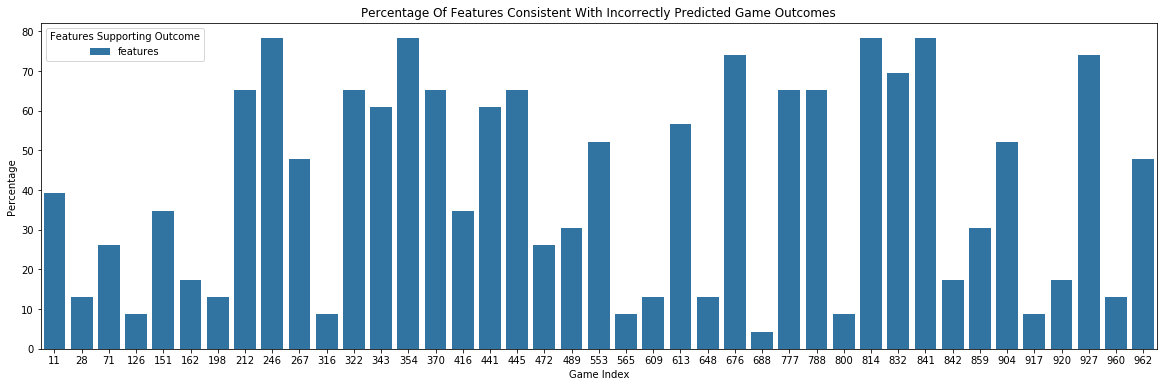

In [54]:
plot_missed_predictions_df = missed_predictions[['game_index','features']]
plot_missed_predictions_df = pd.melt(plot_missed_predictions_df, id_vars='game_index', var_name= 'Features Supporting Outcome')
#plot_missed_predictions_df.head()
m_plot = sns.barplot(x='game_index', y='value', hue='Features Supporting Outcome', data= plot_missed_predictions_df) 
plt.title("Percentage Of Features Consistent With Incorrectly Predicted Game Outcomes")
plt.ylabel('Percentage')
plt.xlabel('Game Index')
m_plot.figure.set_size_inches(20,6)

#### The bar chart depicts the percentage of features that correctly corresponded to the game outcome but were out weighed by other features in predicting the game incorrectly. Games corresponding to bar heights exceeding 50% should be scrutinized.

In [55]:
plot_missed_predictions_df[plot_missed_predictions_df['value'] > 50]

,game_index,Features Supporting Outcome,value
0,904,features,52.173913
3,814,features,78.260870
11,246,features,78.260870
13,788,features,65.217391
15,212,features,65.217391
16,322,features,65.217391
18,676,features,73.913043
20,354,features,78.260870
22,370,features,65.217391
23,832,features,69.565217


##### Examine a missed prediction

In [77]:
missed_prediction_index = 246
# get the list of features that suported the correct game oputcome
list_features =missed_predictions.loc[missed_prediction_index]['supporting_features']

In [57]:
for item in list_features:
    print(item)

margin_victory_avg
off_rebs_avg
def_rebs_avg
to_net_avg
win_pct
off_rating
seed
srs
sos
sag
wlk
wol
rth
col
pom
dol
rpi
mor


In [78]:
missed_game_record = missed_predictions.loc[missed_prediction_index]
missed_game_record

season_t                                                                 2005
round                                                                      32
game_date                                                          2005-03-20
seed_t                                                                     14
team_t                                                               Bucknell
team_id_t                                98d2123a-c7b9-4b5f-8a81-43f76d8537dc
seed_o                                                                      6
team_o                                                              Wisconsin
team_id_o                                c7569eae-5b93-4197-b204-6f3a62146b25
game_result                                                                -1
start_season                                                             2004
game result                                                              Lose
srs_t                                                           

In [80]:
# staged_predict
missed_game = X.loc[missed_prediction_index].to_frame().T
missed_game
staged_predictions = bdt.staged_predict(missed_game)
item_count =0
estimators=[]
values = []
for item in staged_predictions:
    # print(item_count, item)
    estimators.append(item_count)
    values.append(item[0])
    item_count += 1

In [60]:
df = pd.DataFrame.from_dict({'Estimator':estimators,'Value':values})

decision_func = []
for item in bdt.staged_decision_function(missed_game):
    decision_func.append(item[0])
    #print(item)
df['Decision'] = decision_func

predict_prob = []
for item in bdt.staged_predict_proba(missed_game):
    predict_prob.append(item[0][0])
df['Predict_Prob'] = predict_prob 

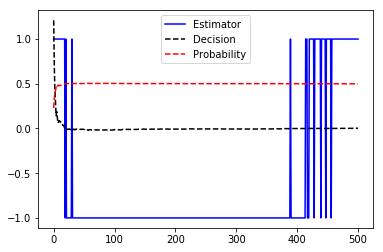

In [82]:
plt.plot('Estimator', 'Value', data= df, marker='', color='blue', label = 'Estimator')
plt.plot('Estimator', 'Decision', data= df, marker='', color='black', linestyle='dashed', label='Decision')
plt.plot('Estimator', 'Predict_Prob', data= df, marker='', color='red', linestyle='dashed', label='Probability')
plt.legend()

In [100]:
# staged_score
staged_score_generator = bdt.staged_score(missed_game,[1])
count =0
for item in staged_score_generator:
    print(count, item)
    count+=1

0 0.0
1 0.0
2 0.0
3 0.0
4 0.0
5 0.0
6 0.0
7 0.0
8 0.0
9 0.0
10 0.0
11 0.0
12 0.0
13 0.0
14 0.0
15 0.0
16 0.0
17 0.0
18 0.0
19 0.0
20 0.0
21 0.0
22 0.0
23 0.0
24 0.0
25 0.0
26 0.0
27 0.0
28 0.0
29 0.0
30 0.0
31 0.0
32 0.0
33 0.0
34 0.0
35 0.0
36 0.0
37 0.0
38 0.0
39 0.0
40 0.0
41 0.0
42 0.0
43 0.0
44 0.0
45 0.0
46 0.0
47 0.0
48 0.0
49 0.0
50 0.0
51 0.0
52 0.0
53 0.0
54 0.0
55 0.0
56 0.0
57 0.0
58 0.0
59 0.0
60 0.0
61 0.0
62 0.0
63 0.0
64 0.0
65 0.0
66 0.0
67 0.0
68 0.0
69 0.0
70 0.0
71 0.0
72 0.0
73 0.0
74 0.0
75 0.0
76 0.0
77 0.0
78 0.0
79 0.0
80 0.0
81 0.0
82 0.0
83 0.0
84 0.0
85 0.0
86 0.0
87 0.0
88 0.0
89 0.0
90 0.0
91 0.0
92 0.0
93 0.0
94 0.0
95 0.0
96 0.0
97 0.0
98 0.0
99 0.0
100 0.0
101 0.0
102 0.0
103 0.0
104 0.0
105 0.0
106 0.0
107 0.0
108 0.0
109 0.0
110 0.0
111 0.0
112 0.0
113 0.0
114 0.0
115 0.0
116 0.0
117 0.0
118 0.0
119 0.0
120 0.0
121 0.0
122 0.0
123 0.0
124 0.0
125 0.0
126 0.0
127 0.0
128 0.0
129 0.0
130 0.0
131 0.0
132 0.0
133 0.0
134 0.0
135 0.0
136 0.0
137 0.0
138 0.

In [66]:
bdt.estimator_errors_

array([0.25703325, 0.41224777, 0.43928499, 0.46013828, 0.40514299,
       0.39307579, 0.42782391, 0.41398466, 0.42852135, 0.43396346,
       0.48193491, 0.45549456, 0.45146546, 0.47250425, 0.4439443 ,
       0.43179956, 0.47351025, 0.45879569, 0.44015841, 0.43724036,
       0.43658177, 0.43856759, 0.45805378, 0.48455448, 0.47768498,
       0.47767067, 0.46902422, 0.45086428, 0.46889975, 0.45179629,
       0.44118125, 0.43215082, 0.44180114, 0.45198404, 0.44729518,
       0.45212942, 0.45068608, 0.44674497, 0.44981174, 0.45878425,
       0.45996154, 0.46062489, 0.45317401, 0.4841318 , 0.4855853 ,
       0.46690579, 0.45304215, 0.46124247, 0.47910545, 0.49121517,
       0.46496486, 0.44952109, 0.4498589 , 0.46997024, 0.44915381,
       0.48269054, 0.448427  , 0.4483582 , 0.44381922, 0.46320562,
       0.48720428, 0.48809572, 0.45467485, 0.46685465, 0.45093943,
       0.45557313, 0.48838211, 0.48301176, 0.47302804, 0.45959744,
       0.46688244, 0.4613705 , 0.46896695, 0.45842423, 0.45833

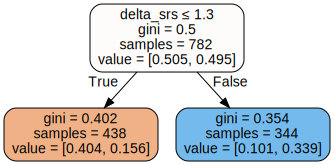

In [83]:
tree_stubs = bdt.estimators_
stub_graph_data = []
for stub in tree_stubs:
    dot_data = tree.export_graphviz(stub,out_file=None, 
                                feature_names= list(X),filled=True, rounded=True, special_characters=True, proportion=False)
    stub_graph_data.append(dot_data)

graphviz.Source(stub_graph_data[0])


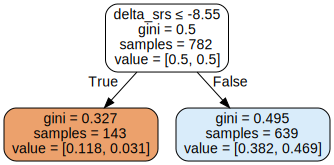

In [84]:
graphviz.Source(stub_graph_data[1])

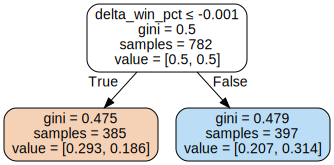

In [86]:
graphviz.Source(stub_graph_data[5])

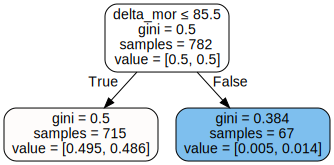

In [102]:
graphviz.Source(stub_graph_data[332])

In [87]:
stub_graph_data[5]

'digraph Tree {\nnode [shape=box, style="filled, rounded", color="black", fontname=helvetica] ;\nedge [fontname=helvetica] ;\n0 [label=<delta_win_pct &le; -0.001<br/>gini = 0.5<br/>samples = 782<br/>value = [0.5, 0.5]>, fillcolor="#399de500"] ;\n1 [label=<gini = 0.475<br/>samples = 385<br/>value = [0.293, 0.186]>, fillcolor="#e581395d"] ;\n0 -> 1 [labeldistance=2.5, labelangle=45, headlabel="True"] ;\n2 [label=<gini = 0.479<br/>samples = 397<br/>value = [0.207, 0.314]>, fillcolor="#399de557"] ;\n0 -> 2 [labeldistance=2.5, labelangle=-45, headlabel="False"] ;\n}'

In [88]:
 bdt.estimators_[5]

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False,
            random_state=549191225, splitter='best')

In [ ]:
help(tree._tree.Tree)


In [92]:
stub_5 =  bdt.estimators_[5]
stub_5.classes_


array([-1,  1], dtype=int64)

In [93]:
stub_5.tree_.value

array([[[0.5       , 0.5       ]],

       [[0.29308331, 0.1861591 ]],

       [[0.20691669, 0.3138409 ]]])

In [94]:
stub_5.tree_.weighted_n_node_samples

array([1.        , 0.47924241, 0.52075759])

In [95]:
stub_5.tree_.n_node_samples

array([782, 385, 397], dtype=int64)

In [96]:
stub_5.tree_.impurity

array([0.5       , 0.47511076, 0.47892096])